In [1]:
%matplotlib inline
import pylab
import pandas as pd

In [2]:
#sample_id='SRR606249'
#sample_id = 'p8808mo9'
sample_id = 'p8808mo11'
outdir = 'outputs.paper'


In [3]:
from IPython.display import Markdown as md
from IPython.display import display
md(f"# genome-grist report for metagenome `{sample_id}`")

# genome-grist report for metagenome `p8808mo11`

## load mapping summary CSVs and gather CSV

In [4]:

# load mapping CSVs
all_df = pd.read_csv(f'../../{outdir}/minimap/{sample_id}.summary.csv')
left_df = pd.read_csv(f'../../{outdir}/leftover/{sample_id}.summary.csv')

# load gather CSV
gather_df = pd.read_csv(f'../../{outdir}/genbank/{sample_id}.x.genbank.gather.csv')

# names!
names_df = pd.read_csv(f'../../{outdir}/genbank/{sample_id}.genomes.info.csv')

# connect gather_df to all_df and left_df using 'genome_id'
def fix_name(x):
    return "_".join(x.split('_')[:2]).split('.')[0]

gather_df['genome_id'] = gather_df['name'].apply(fix_name)
names_df['genome_id'] = names_df['acc'].apply(fix_name)

In [5]:
# CTB bug FIXME
# this ensures that only rows that share genome_id are in all the dataframes
in_gather = set(gather_df.genome_id)
in_left = set(left_df.genome_id)

in_both = in_left.intersection(in_gather)

all_df = all_df[all_df.genome_id.isin(in_both)]
left_df = left_df[left_df.genome_id.isin(in_both)]
gather_df = gather_df[gather_df.genome_id.isin(in_both)]
names_df = names_df[names_df.genome_id.isin(in_both)]

# reassign index now that we've maybe dropped rows
all_df.index = range(len(all_df))
left_df.index = range(len(left_df))
gather_df.index = range(len(gather_df))
names_df.index = range(len(names_df))

assert len(all_df) == len(gather_df)
assert len(left_df) == len(gather_df)
assert len(names_df) == len(gather_df)

In [6]:
# re-sort left_df and all_df to match gather_df order, using matching genome_id column
all_df = all_df.set_index("genome_id")
all_df = all_df.reindex(index=gather_df["genome_id"])
all_df = all_df.reset_index()

left_df = left_df.set_index("genome_id")
left_df = left_df.reindex(index=gather_df["genome_id"])
left_df = left_df.reset_index()

#left_df["mapped_bp"] = (1 - left_df["percent missed"]/100) * left_df["genome bp"]
#left_df["unique_mapped_coverage"] = left_df.coverage / (1 - left_df["percent missed"] / 100.0)

names_df = names_df.set_index("genome_id")
names_df = names_df.reindex(index=gather_df["genome_id"])
names_df = names_df.reset_index()

None
#names_df[:3]

In [7]:
#left_df[:5]

In [8]:
#gather_df[:5]

In [9]:
# subsample? take top 60...

NUM=60

left_df = left_df[:NUM]
all_df = all_df[:NUM]
gather_df = gather_df[:NUM]
names_df = names_df[:NUM]

## fig 1: examining leftover reads, in order of gather

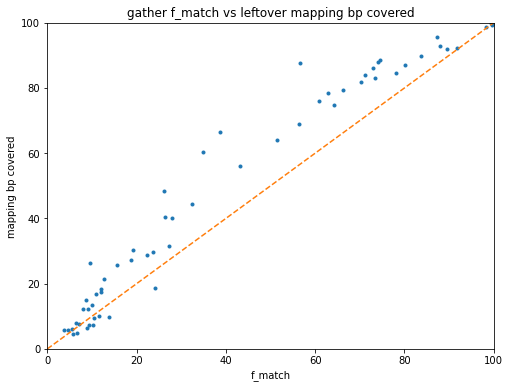

In [10]:
pylab.figure(num=None, figsize=(8, 6))
pylab.plot(gather_df["f_match"]* 100, 100 - left_df["percent missed"], '.')

pylab.xlim(0, 100)
pylab.ylim(0, 100)
pylab.xlabel('f_match')
pylab.ylabel('mapping bp covered')
pylab.title('gather f_match vs leftover mapping bp covered')
pylab.plot([0, 100], [0, 100], '--')

## fig 2: fraction of hashes unique to query, in order of gather results

Text(0, 0.5, 'f_unique_to_query, as %')

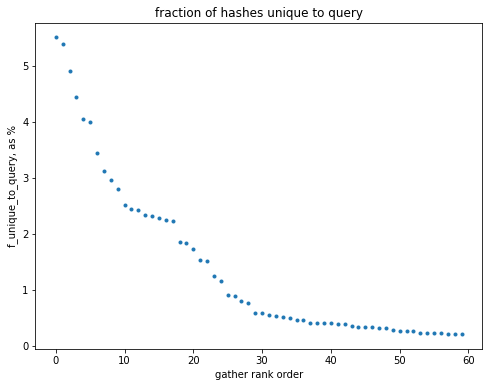

In [11]:
pylab.figure(num=None, figsize=(8, 6))
pylab.plot(gather_df.index, gather_df["f_unique_to_query"]*100, '.')

pylab.title('fraction of hashes unique to query')
pylab.xlabel('gather rank order')
pylab.ylabel('f_unique_to_query, as %')

## fig 4: sum mapped bp and sum identified hashes, in order of gather

conclusion: across the gather run, total hashes identified correlate well with total bp mapped

Text(0.5, 1.0, 'p8808mo11: gather remaining hashes vs remaining bp')

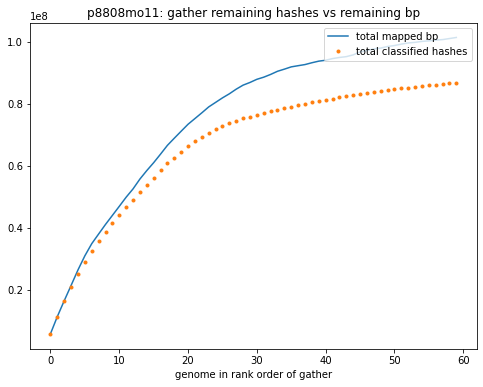

In [12]:
pylab.figure(num=None, figsize=(8, 6))
pylab.plot(left_df.index, left_df["covered_bp"].cumsum(), '-', label='total mapped bp')
pylab.plot(gather_df.index, gather_df["unique_intersect_bp"].cumsum(), '.', label='total classified hashes')

pylab.xlabel('genome in rank order of gather')
pylab.legend(loc='upper right')
pylab.title(f'{sample_id}: gather remaining hashes vs remaining bp')


## fig 5: mapped bp and identified hashes compared by sample, in order of gather

conclusion: for most samples, bp mapped to that genome matches # of hashes classified to that genome

note: hashes classified to this genome is monotonically decreasing, b/c gather is a greedy algorithm.

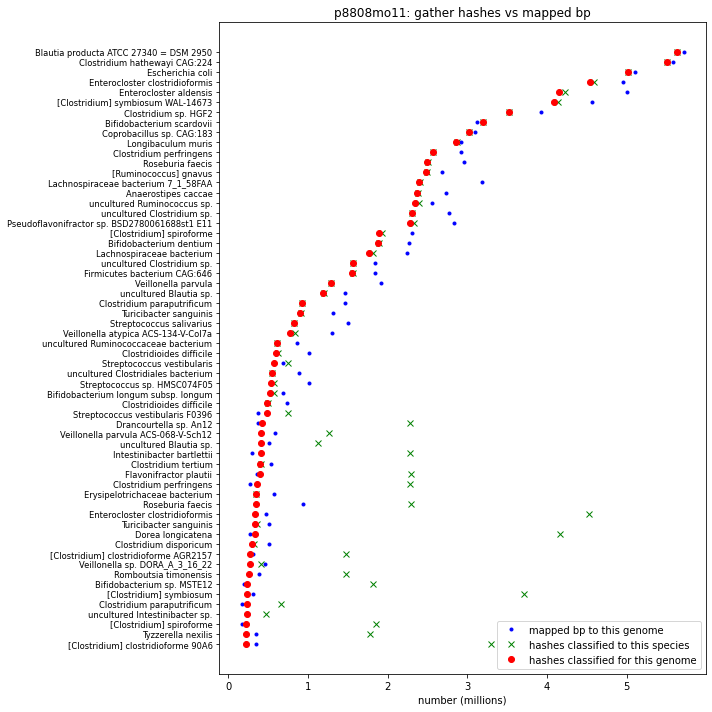

In [13]:
pylab.figure(num=None, figsize=(10, 10))

pylab.plot(left_df.covered_bp / 1e6, left_df.iloc[::-1].index, 'b.', label='mapped bp to this genome')
pylab.plot(gather_df.intersect_bp / 1e6, gather_df.iloc[::-1].index, 'gx', label='hashes classified to this species')
pylab.plot(gather_df.unique_intersect_bp / 1e6, gather_df.iloc[::-1].index, 'ro', label='hashes classified for this genome')

positions = list(gather_df.index)
labels = list(reversed(names_df.ncbi_tax_name))
pylab.yticks(positions, labels, fontsize='small')

pylab.xlabel('number (millions)')
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: gather hashes vs mapped bp')
pylab.tight_layout()



## fig 6: difference between hashes ident and bp mapped

Text(0, 0.5, 'difference: hashcount - mapped bp')

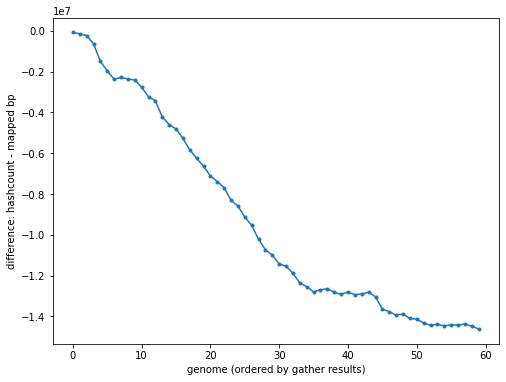

In [14]:
pylab.figure(num=None, figsize=(8, 6))
pylab.plot(gather_df.index, gather_df.unique_intersect_bp.cumsum() - left_df.covered_bp.cumsum(), '.-')

pylab.xlabel('genome (ordered by gather results)')
pylab.ylabel('difference: hashcount - mapped bp')

## fig 7: difference between hashes and bp, per sample

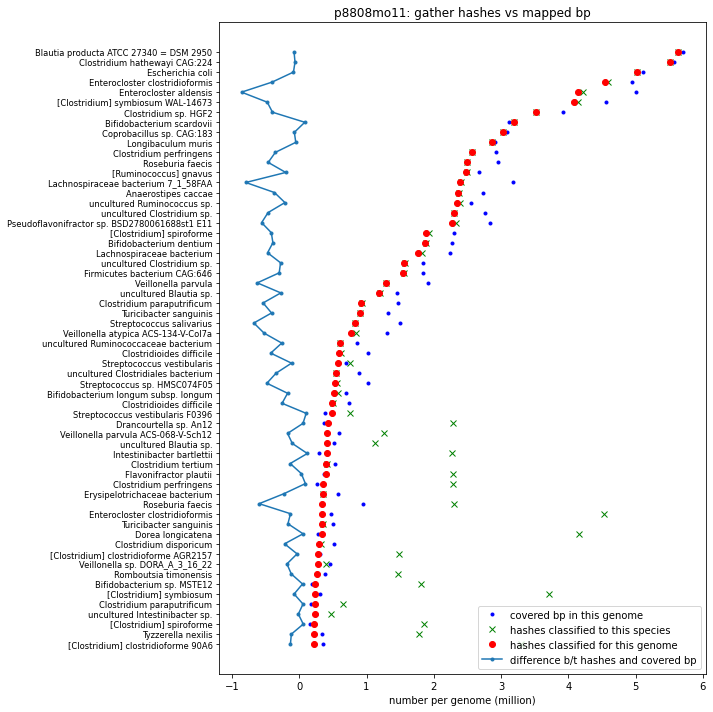

In [15]:
pylab.figure(num=None, figsize=(10, 10))

pylab.plot(left_df.covered_bp / 1e6, left_df.iloc[::-1].index, 'b.', label='covered bp in this genome')
pylab.plot(gather_df.intersect_bp / 1e6, gather_df.iloc[::-1].index, 'gx', label='hashes classified to this species')
pylab.plot(gather_df.unique_intersect_bp / 1e6, gather_df.iloc[::-1].index, 'ro', label='hashes classified for this genome')

pylab.plot((gather_df.unique_intersect_bp - left_df.covered_bp) / 1e6, gather_df.iloc[::-1].index, 
           '.-', label='difference b/t hashes and covered bp')

positions = list(gather_df.index)
labels = list(reversed(names_df.ncbi_tax_name))
pylab.yticks(positions, labels, fontsize='small')

#pylab.ylabel('genome (ordered by gather results)')
pylab.xlabel('number per genome (million)')
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: gather hashes vs mapped bp')
pylab.tight_layout()

## fig 8: correlation between hashes and mapping rates

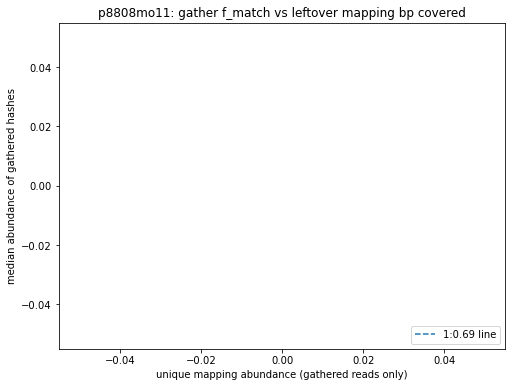

In [16]:
pylab.figure(num=None, figsize=(8, 6))
pylab.plot(left_df.unique_mapped_coverage, gather_df.median_abund, 'ro')
max_x = max(left_df.unique_mapped_coverage)
max_y = max(gather_df.median_abund)
pylab.plot([0, max_x], [0, max_y * 186/270], '--', label="1:0.69 line")
pylab.xlabel('unique mapping abundance (gathered reads only)')
pylab.ylabel('median abundance of gathered hashes')
pylab.title(f'{sample_id}: gather f_match vs leftover mapping bp covered')
pylab.legend(loc='lower right')

## fig 9: percentage of each genome covered by mapped reads

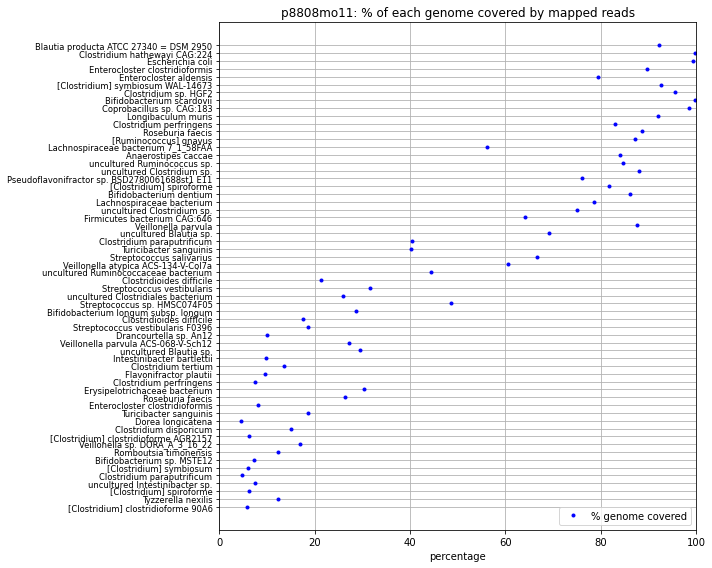

In [17]:
pylab.figure(num=None, figsize=(10, 8))

left_df['f_covered'] = left_df['covered_bp'] / left_df['genome bp']
pylab.plot(left_df.f_covered * 100, left_df.iloc[::-1].index, 'b.', label='% genome covered')
#pylab.plot(gather_df.intersect_bp / 1e6, gather_df.iloc[::-1].index, 'gx', label='hashes classified to this species')
#pylab.plot(gather_df.unique_intersect_bp / 1e6, gather_df.iloc[::-1].index, 'ro', label='hashes classified for this genome')

positions = list(gather_df.index)
labels = list(reversed(names_df.ncbi_tax_name))
pylab.yticks(positions, labels, fontsize='small')

pylab.xlabel('percentage')
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: % of each genome covered by mapped reads')
pylab.axis(xmin=0, xmax=100)
pylab.grid(True)
pylab.tight_layout()

## fig 10: per-genome coverage estimates from mapped reads

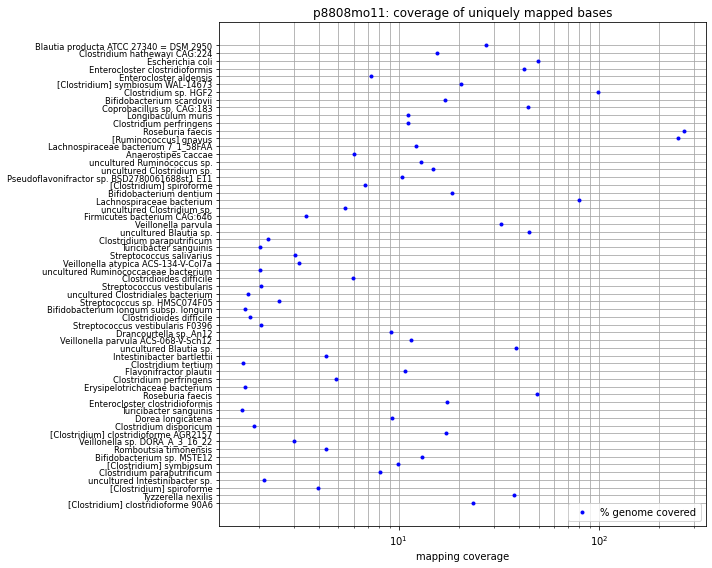

In [18]:
pylab.figure(num=None, figsize=(10, 8))

pylab.plot(left_df.unique_mapped_coverage, left_df.iloc[::-1].index, 'b.', label='% genome covered')
#pylab.plot(gather_df.intersect_bp / 1e6, gather_df.iloc[::-1].index, 'gx', label='hashes classified to this species')
#pylab.plot(gather_df.unique_intersect_bp / 1e6, gather_df.iloc[::-1].index, 'ro', label='hashes classified for this genome')

positions = list(gather_df.index)
labels = list(reversed(names_df.ncbi_tax_name))
pylab.yticks(positions, labels, fontsize='small')

pylab.xlabel('mapping coverage')
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: coverage of uniquely mapped bases')
#pylab.axis(xmin=0)
pylab.grid(True)
pylab.grid(True, which="both", ls="-", color='0.65')
pylab.xscale('log')
pylab.tight_layout()

## fig 11: per-genome number of variants in metagenome

(called against uniquely mapped portions of reference genomes)

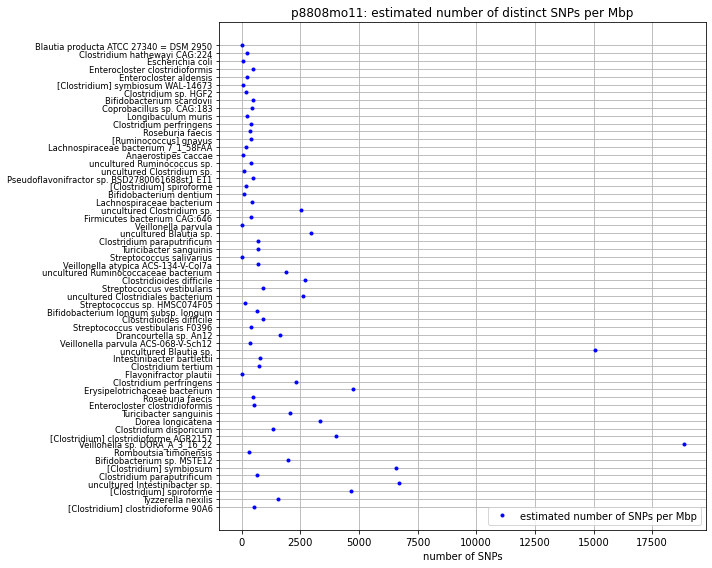

In [19]:
pylab.figure(num=None, figsize=(10, 8))

pylab.plot(left_df.n_snps * 1e6 / left_df['covered_bp'],
           left_df.iloc[::-1].index, 'b.', label='estimated number of SNPs per Mbp')

positions = list(gather_df.index)
labels = list(reversed(names_df.ncbi_tax_name))
pylab.yticks(positions, labels, fontsize='small')

pylab.xlabel('number of SNPs')
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: estimated number of distinct SNPs per Mbp')
pylab.grid(True)
pylab.tight_layout()
pylab.savefig(f'/tmp/snps-{sample_id}.pdf')
pylab.savefig(f'/tmp/snps-{sample_id}.png')

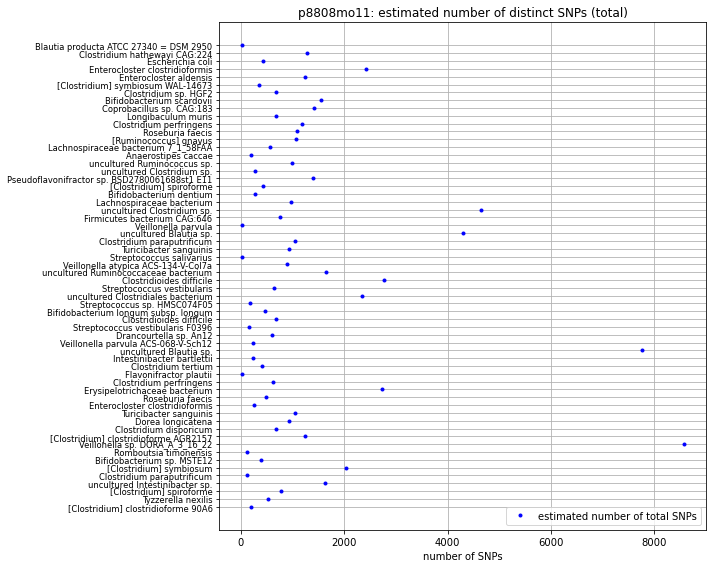

In [20]:
pylab.figure(num=None, figsize=(10, 8))

pylab.plot(left_df.n_snps,
           left_df.iloc[::-1].index, 'b.', label='estimated number of total SNPs')

positions = list(gather_df.index)
labels = list(reversed(names_df.ncbi_tax_name))
pylab.yticks(positions, labels, fontsize='small')

pylab.xlabel('number of SNPs')
pylab.legend(loc='lower right')
pylab.title(f'{sample_id}: estimated number of distinct SNPs (total)')
pylab.grid(True)
pylab.tight_layout()
pylab.savefig(f'/tmp/snps-{sample_id}.pdf')
pylab.savefig(f'/tmp/snps-{sample_id}.png')